In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-17 20:00:00   290.85   290.85   290.8     290.8     1186.0
2022-02-17 19:59:00   290.70   290.70   290.7     290.7      598.0


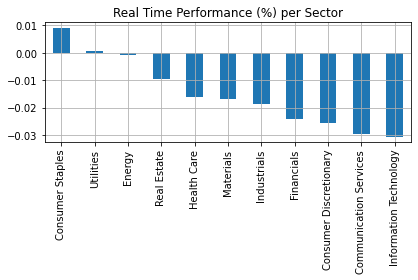

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

124.9700


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
135     DGRO
136     TD6C
137     TDG0
138    PTTRX
139      NaN
Name: Ticker, Length: 140, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
15-Feb - UP (43.6000)
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb - UP (64.9900)
17-Feb
27-Jan - UP (319.1700)
09-Feb - UP (8.8500)
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
16-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb - UP (80.9100)
22-Feb
09-Feb - UP (205.9100)
09-Feb - UP (152.1600)
28-Feb
23-Feb
16-Feb
16-Feb - DN (746.8500)
26-Jan - UP (228.2200)
15-Feb - DN (89.0600)
21-Feb
28-Feb
23-Feb
08-Feb - UP (8.5800)
22-Feb
15-Feb - UP (61.9700)
15-Feb - UP (11.8800)
28-Feb
08-Feb - UP (364.9400)
03-Feb - UP (138.1800)
08-Feb - UP (37.2700)
10-Feb - DN (51.3400)
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb - UP (629.8000)
22-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
16-Feb
16-Feb
15-Feb - UP (148.0100)
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb - UP (129.9400)
10-Feb - UP (544.9200)
21-Feb
01-

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [28]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTALCURRENTASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [36]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [37]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [95]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1699838/000095017021001629/cflt-20210805ex99_1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA)
ORIGINAL TABLE  0
                                       0        1        2           3
0                                    NaN      NaN      NaN         NaN
1                                    NaN  Q2 2021  Q2 2020  Y/Y Change
2                          Total Revenue    $88.3    $53.9         64%
3      Remaining Performance Obligations   $327.2   $190.6         72%
4                    GAAP Operating Loss  $(86.0)  $(27.5)     $(58.5)
5                Non-GAAP Operating Loss  $(36.8)  $(20.4)     $(16.4)
6                GAAP Net Loss Per Share  $(0.74)  $(0.25)     $(0.49)
7            Non-GAAP Net Loss Per Share  $(0.31)  $(0.19)     $(0.12)
8  Net Cash Used in Operating Activities  $(43.2)  $(21.5)     $(21.7)
9                         Free Cash Flow  $(45.4)  $(22.7)     $(22.7)
HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                  METRIC  Q2 2021  Q2 2020 Y/Y CHANGE

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHE

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP OPERATING LOSS TO NON-G...   
4                      OPERATING LOSS ON A GAAP BASIS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6   ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
7        ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
8                             NON-GAAP OPERATING LOSS   
9                           NON-GAAP OPERATING MARGIN   
11  RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
12                           NET LOSS ON A GAAP BASIS   
13               ADD STOCK-BASED COMPENSATION EXPENSE   
14  ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
15       ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
16             ADD INCOME TAX EFFECTS AND ADJUSTMENTS   
17                                  NON-GAAP NET LOSS   
18  NON-GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CO...   
19  WEIGHTED

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [73]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Quote for stock ENB on earning date 15-Feb - UP (43.6000) already generated
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning report for stock KNSL on date 2022-02-17 exists
Earning released for stock KNSL AH
Get price diff for stock KNSL from date 2022-02-17 and date 2022-02-18
Update Stock KNSL with quote 17-Feb
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Earning report for stock APPN on date 2022-02-17 exists
Earning released for stock APPN AH
Get price diff

Update Stock DKNG with quote 18-Feb
Earning for stock DPZ will be released later on 2022-03-01
Quote for stock DPZ on earning date 01-Mar not generated yet
Quote for stock FB on earning date 02-Feb - DN (237.7600) already generated
Earning for stock PUBM will be released later on 2022-02-21
Quote for stock PUBM on earning date 21-Feb not generated yet
Earning for stock OKTA will be released later on 2022-03-01
Quote for stock OKTA on earning date 01-Mar not generated yet
Earning for stock RH will be released later on 2022-03-22
Quote for stock RH on earning date 22-Mar not generated yet
Quote for stock YNDX on earning date 15-Feb - UP (52.4000) already generated
Earning for stock RVLV will be released later on 2022-02-22
Quote for stock RVLV on earning date 22-Feb not generated yet
Earning for stock ETSY will be released later on 2022-02-23
Quote for stock ETSY on earning date 23-Feb not generated yet
Earning for stock VIR will be released later on 2022-02-23
Quote for stock VIR on ear

In [45]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [47]:
stocks = get_earningDates(d, "TD")
print(stocks, "\n", len(stocks))

[['DKNG', '18-Feb-2022']] 
 1


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [48]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [50]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [51]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [52]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [53]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [54]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [55]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [56]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [57]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [58]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [59]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [60]:
def isBold(tag, ctext):
    listag = ["ul", "li"]
    if((tag.name == "b" and tag.parent.name not in listag) or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [61]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tags), ctag.name, ctag.text, tags)
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.name == "u"):
                continue
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [62]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [63]:
def isPadLeft(item):
    if(item.name == "ul" or item.name == "li"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [64]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [65]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    listag = ["ul", "li"]
    if not txt:
        if(item.name in listag):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", " ")
    ctext = ctext.replace("     ", " ")
    ctext = ctext.replace("    ", " ")
    ctext = ctext.replace("   ", " ")
    ctext = ctext.replace("  ", " ")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name not in listag and item.parent.name not in listag):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [66]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [67]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata)
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [68]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    hc = False #Header continue to next row
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            hc = False
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met.upper() and "PER SHARE" not in met.upper() and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met.upper() or "EPS" in met.upper())):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
                hc = True
            else:
                if hc:
                    header = header + " " + met
                else:
                    header = met
        elif(met == "TOTAL"):
            header = None
        else:
            hc = False
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [69]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br", "li"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul" and len(tag.findChildren("li", recursive=True)) == 0):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "li" and len(tag.findChildren("li", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [77]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2022-02-17"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [79]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477333/000119312522034540/d243920dex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1441683/000144168322000022/appnex991earningsrelease-1.htm"
source = getPgSource(url)

In [80]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 5

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                              Assets   
5                                      Current assets   
6                           Cash and cash equivalents   
7    Short-term investments and marketable securities   
8   Accounts receivable, net of allowance of $1,40...   
9                       Deferred commissions, current   
10          Prepaid expenses and other current assets   
11                           Restricted cash, current   
12                               Total current assets   
13                        Property and equipment, net   
14                              Long-term investments   
15              


FINAL REPORT
                                               METRIC AS OF DECEMBER 31, 2021  \
4                                              ASSETS                     nan   
5                                      CURRENT ASSETS                     nan   
6                           CASH AND CASH EQUIVALENTS                 $100796   
7    SHORT-TERM INVESTMENTS AND MARKETABLE SECURITIES                   55179   
8   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE OF $, AS...                  130049   
9                       DEFERRED COMMISSIONS, CURRENT                   24668   
10          PREPAID EXPENSES AND OTHER CURRENT ASSETS                   26781   
11                           RESTRICTED CASH, CURRENT                     791   
12                               TOTAL CURRENT ASSETS                  338264   
13                        PROPERTY AND EQUIPMENT, NET                   36913   
14                              LONG-TERM INVESTMENTS                   12044   
15            


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                       SUBSCRIPTIONS   
6                               PROFESSIONAL SERVICES   
7                                       TOTAL REVENUE   
8                                     COST OF REVENUE   
9                                       SUBSCRIPTIONS   
10                              PROFESSIONAL SERVICES   
11                              TOTAL COST OF REVENUE   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                                SALES AND MARKETING   
15                           RESEARCH AND DEVELOPMENT   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                                     OPERATING LOSS   
19                             OTHER (INCOME) EXPENSE   
20               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                                    BAD DEBT EXPENSE   
8          LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
9   CHANGE IN FAIR VALUE OF AVAILABLE-FOR-SALE SEC...   
10                              DEFERRED INCOME TAXES   
11                           STOCK-BASED COMPENSATION   
12                  CHANGES IN ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                  PREPAID EXPENSES AND OTHER ASSETS   
15                               DEFERRED COMMISSIONS   
16              ACCOUNTS PAYABLE AND ACCRUED EXPENSES   
17          ACCRUED COMPENSATION AND RELATED BENEFITS   
18 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3           RECONCILIATION OF NON-GAAP OPERATING LOSS   
4                                 GAAP OPERATING LOSS   
5                                            ADD BACK   
6                    STOCK-BASED COMPENSATION EXPENSE   
7                                 LITIGATION EXPENSES   
8                             NON-GAAP OPERATING LOSS   
10                RECONCILIATION OF NON-GAAP NET LOSS   
11                                      GAAP NET LOSS   
12                                           ADD BACK   
13                   STOCK-BASED COMPENSATION EXPENSE   
14                                LITIGATION EXPENSES   
15         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
16                                  NON-GAAP NET LOSS   
18                        NON-GAAP EARNINGS PER SHARE   
19                                  NON-GA

In [81]:
allTables

{'TOTAL': 5,
 'PARSESUCCESS': [0, 1, 2, 3, 4],
 'PARSEFAIL': [],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":null,"1":null,"2":null,"3":"As of","4":"As of","5":"As of","6":"As of","7":"As of","8":"As of","9":"As of","10":"As of","11":"As of"},{"0":null,"1":null,"2":null,"3":"December 31, 2021","4":"December 31, 2021","5":"December 31, 2021","6":null,"7":null,"8":null,"9":"December 31, 2020","10":"December 31, 2020","11":"December 31, 2020"},{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"Assets","1":"Assets","2":"Assets","3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"Current assets","1":"Current assets","2":"Current assets","3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"Cash and cash equivalents","1":"Cash and cash equivalents","2":"Cash and 

In [82]:
csym = "APPN"
rptDest = "../../Summary/EDGAR/8-K/"+csym
textFilename = rptDest+"/APPN_2022-02-17_EP.txt"
testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
#testOne8KEdgarRpt(url, csym, None, source, allTables)

NOPAD*** Document.


SC*** Appian Announces Fourth Quarter and Full Year 2021 Financial Results.

NOPAD*** Fourth quarter cloud subscription revenue increased 39% year-over-year to $51.2 million.

NOPAD*** Full year cloud subscription revenue increased 39% year-over-year to $179.4 million.


SC*** McLean, VA – February 17, 2022 – Appian (Nasdaq: APPN) today announced financial results for the fourth quarter and full year ended December 31, 2021.

NOPAD*** "Appian cloud subscription revenue grew 39% for the full year. We enter 2022 with an accelerating business, a unified low-code platform, a growing ecosystem, and happy customers," said Matt Calkins, CEO & Founder.


SC*** Fourth Quarter 2021 Financial Highlights:.


SC*** Full Year 2021 Financial Highlights:.

NOPAD*** A reconciliation of GAAP to non-GAAP financial measures has been provided in the tables following the financial statements in this press release. An explanation of these measures is also included below under the heading

In [71]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [108]:
csym = "PLTR"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/PLTR'
1321655
8K URL https://www.sec.gov/Archives/edgar/data/1321655/0001193125-20-251414-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1321655/000119312520251414/d11024dex991.htm
NUMBER OF TABLES 8

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  • NaN  Revenue: $278 million to $280 million, represe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  • NaN  Non-GAAP Operating Income: $60 million to $62 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  • NaN  Stock-Based Compensation: Approximately $815 m...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FO

HEADERSSSSSSSSS ['0:1']
{0: [1], 2: [3], 4: [5], 6: [7]}

FINAL REPORT
                                               METRIC  \
3                                              ASSETS   
4                                      CURRENT ASSETS   
5                           CASH AND CASH EQUIVALENTS   
6                                     RESTRICTED CASH   
7                                 ACCOUNTS RECEIVABLE   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                               TOTAL CURRENT ASSETS   
11                        PROPERTY AND EQUIPMENT, NET   
12                        RESTRICTED CASH, NONCURRENT   
13                                       OTHER ASSETS   
15                                       TOTAL ASSETS   
17  LIABILITIES, REDEEMABLE CONVERTIBLE AND CONVER...   
18                                CURRENT LIABILITIES   
19                                   ACCOUNTS PAYABLE   
20                                ACCRUED LIABILITIES   
21               

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.

NOPAD*** Third Quarter 2020.

NOPAD*** Financial Results.


SC*** PalantirTechnologies Inc.

NOPAD*** (NYSE: PLTR).


SC*** Palantir Reports Revenue Growth of 52% in the Third Quarter,.


SC*** Raises Full-Year 2020 Guidance.

NOPAD*** New Contracts with U.S. Army and National Institutes of Health;.

NOPAD*** $300 Million Renewal with Aerospace Customer Announced.

NOPAD*** November 12, 2020.

NOPAD*** Palantir TechnologiesInc. reported its financial results today for the third quarter of 2020.


SC*** Summary.

TABLEEEEEEEEEEE 0
• $289.4 million in revenue in the third quarter, up 52% year - over - year
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• Full - year 2020 revenue guidance raised  a range of $1.070 billion  $1.072 billion, up 44% year - over - year
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• New contracts in third quarter include U.S. Army ($91 million), National Institutes of Health ($36 million), and $300 million renewal with aerospace customer


8K URL https://www.sec.gov/Archives/edgar/data/1321655/0001193125-21-013558-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1321655/000119312521013558/d949109dex991.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1321655/000119312521013558/d949109dex991.htm
8K URL https://www.sec.gov/Archives/edgar/data/1321655/0001193125-21-043333-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1321655/000119312521043333/d131078dex991.htm
NUMBER OF TABLES 14

FOR TABLE 0

TABLE DESCRIPTION:   
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  • NaN  $1.1 billion in revenue for full year 2020, up...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  • NaN  $322 million in revenue for Q4 2020, up 40% ye...
HEADERSSSSSSSSS ['0:0']
{}
HEADER FOR EMPTY ROW
    0                               

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDEDDECEMBER 31, 2020  \
3                         COST OF REVENUE                              $19342   
4                     SALES AND MARKETING                               75852   
5                RESEARCH AND DEVELOPMENT                               47365   
6              GENERAL AND ADMINISTRATIVE                               99229   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE                             $241788   

  THREE MONTHS ENDEDDECEMBER 31, 2019 YEARS ENDEDDECEMBER 31, 2020  \
3                              $11384                      $139627   
4                               22973                       398205   
5                               18796                       357063   
6                               24167                       375807   
8                              $77320                     $1270702   

  YEARS ENDEDDECEMBER 31, 201

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Palantir Reports Revenue Growth of 47% for Full Year 2020, Expects Q1 2021 Revenue Growth of 45%.

NOPAD*** 2/16/2021.


SC*** Summary.

TABLEEEEEEEEEEE 0
• $1.1 billion in revenue for full year 2020, up 47% year - over - year
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
TABLE 1 PARSED SUCCESSFULLY
POSSIBLE EARNING MONTH STR ['FULL YEAR', 'FULL-YEAR', 'FULL FISCAL', 'FISCAL', 'Q1', 'Q4', 'DEC', 'DECEMBER', '12/', '/12', 'MAR', 'MARCH', '3/', '/3', 'GUIDANCE', 'FY', 'FOURTH', 'FIRST']
POSSIBLE EARNING YEAR STR ['2020', 'FY20', 'FY20GUIDANCE', '2021', 'FY21', 'FY21GUIDANCE', '2020', 'FY20', 'FY20GUIDANCE']
  METRIC $322 MILLION IN REVENUE FOR Q4 2020, UP 40% YEAR-OVER-YEAR
0      •  $322 MILLION IN REVENUE FOR Q4 2020, UP 40% YE...        
1 $322 MILLION IN REVENUE FOR Q4 2020, UP 40% YEAR  $OVER%  
1 $322 MILLION IN REVENUE FOR Q4 2020, UP 40% YEAR  $YEAR%  
$322 Million In Revenue For Q4 2020, Up 40% Year-over-year None • $322 MILLION IN REVENUE 


FINAL REPORT
                                  METRIC AMOUNT FIRST QUARTER 2021  \
6                   LOSS FROM OPERATIONS                  $(114014   
7        ADJUSTED INCOME FROM OPERATIONS                   $116583   
8              CASH FLOW FROM OPERATIONS                   $116881   
9                ADJUSTED FREE CASH FLOW                   $150975   
10                              NET LOSS                  $(123474   
11                   ADJUSTED NET INCOME                    $82651   
12                       ADJUSTED EBITDA                   $119820   
13      GAAP NET LOSS PER SHARE, DILUTED                    $(0.07   
14  ADJUSTED EARNINGS PER SHARE, DILUTED                     $0.04   

   NAN FIRST QUARTER 2021 MARGIN FIRST QUARTER 2021  
6                       )                     (33)%  
7                     nan                       34%  
8                     nan                       34%  
9                     nan                       44%  
10             

FINAL REPORT
                                           METRIC  \
3                                          ASSETS   
4                                  CURRENT ASSETS   
5                       CASH AND CASH EQUIVALENTS   
6                                 RESTRICTED CASH   
7                             ACCOUNTS RECEIVABLE   
8       PREPAID EXPENSES AND OTHER CURRENT ASSETS   
10                           TOTAL CURRENT ASSETS   
11                    PROPERTY AND EQUIPMENT, NET   
12                    RESTRICTED CASH, NONCURRENT   
13            OPERATING LEASE RIGHT-OF-USE ASSETS   
14                                   OTHER ASSETS   
16                                   TOTAL ASSETS   
19            LIABILITIES AND STOCKHOLDERS EQUITY   
20                            CURRENT LIABILITIES   
21                               ACCOUNTS PAYABLE   
22                            ACCRUED LIABILITIES   
23                               DEFERRED REVENUE   
24                              C

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                              METRIC  \
3  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
4           LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5  ADD CASH PAID FOR EMPLOYER PAYROLL TAXES RELAT...   
7                            ADJUSTED FREE CASH FLOW   
9                     ADJUSTED FREE CASH FLOW MARGIN   

  THREE MONTHS ENDEDMARCH 31, 2021 THREE MONTHS ENDEDMARCH 31, 2020  
3                          $116881                        $(287184)  
4                            (708)                           (3016)  
5                            34802                              nan  
7                          $150975                        $(290200)  
9                              44%                           (127)%  

FOR TABLE 19

TABLE DESCRIPTION:   
ORIGINAL TABLE  19
                                                    0   1  \
0                                                 NaN NaN   
1                         

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Palantir Reports 49% Revenue Growth; $117M in Cash Flow from Operations, up $404M Y/Y; and $151M in Adj. Free Cash Flow, up $441M Y/Y for Q1 2021.

NOPAD*** 5/11/2021.


SC*** DENVER — (BUSINESS WIRE) — PalantirTechnologies Inc. (NYSE:PLTR) today announced financial results for the first quarter ended March 31, 2021.


SC*** Q1 2021 Highlights.

TABLEEEEEEEEEEE 0
• Total revenue grew 49% year - over - year  $341 million
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• US commercial revenue grew 72% year - over - year
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• US government revenue grew 83% year - over - year
TABLEEEE CNTTTTT 3
TABLEEEEEEEEEEE 3
• Cash flow from operations of $117 million, up $404 million year - over - year, and representing a 34% margin
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
• Adjusted free cash flow of $151 million, up $441 million year - over - year, and representing a 44% margin
TABLEEEE CNTTTTT 5
TABLEEEEEEEEEEE 5
• GAAP net loss per

{1: [2], 3: [4], 5: [6, 7]}

FINAL REPORT
                                  METRIC AMOUNT SECOND QUARTER 2021  \
6                   LOSS FROM OPERATIONS                   $(146148   
7        ADJUSTED INCOME FROM OPERATIONS                    $116727   
8              CASH FLOW FROM OPERATIONS                     $22750   
9                ADJUSTED FREE CASH FLOW                     $49823   
10                              NET LOSS                   $(138580   
11                   ADJUSTED NET INCOME                     $97955   
12                       ADJUSTED EBITDA                    $121489   
13      GAAP NET LOSS PER SHARE, DILUTED                     $(0.07   
14  ADJUSTED EARNINGS PER SHARE, DILUTED                      $0.04   

   NAN SECOND QUARTER 2021 MARGIN SECOND QUARTER 2021  
6                        )                      (39)%  
7                      nan                        31%  
8                      nan                         6%  
9                      

HEADERSSSSSSSSS ['0:0']
{1: [2], 4: [5]}

FINAL REPORT
                                           METRIC JUNE 30,2021  \
2                                          ASSETS          nan   
3                                  CURRENT ASSETS          nan   
4                       CASH AND CASH EQUIVALENTS     $2341156   
5                                 RESTRICTED CASH        36750   
6                             ACCOUNTS RECEIVABLE       242998   
7       PREPAID EXPENSES AND OTHER CURRENT ASSETS        41648   
9                            TOTAL CURRENT ASSETS      2662552   
10                    PROPERTY AND EQUIPMENT, NET        24824   
11                    RESTRICTED CASH, NONCURRENT        61914   
12            OPERATING LEASE RIGHT-OF-USE ASSETS       209243   
13                                   OTHER ASSETS       117135   
15                                   TOTAL ASSETS     $3075668   
17            LIABILITIES AND STOCKHOLDERS EQUITY          nan   
18                   

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
3  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
4           LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5  ADD CASH PAID FOR EMPLOYER PAYROLL TAXES RELAT...   
7                            ADJUSTED FREE CASH FLOW   
9                     ADJUSTED FREE CASH FLOW MARGIN   

  THREE MONTHS ENDEDJUNE 30, 2021 THREE MONTHS ENDEDJUNE 30, 2020  \
3                          $22750                          $60854   
4                            (697                           (2929   
5                           27770                             nan   
7                          $49823                          $57925   
9                             13%                             23%   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
3                       $139631                      $(226330  
4                         (1405                      

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Palantir Reports 49% Revenue Growth; US Commercial Revenue Up 90% Y/Y.

NOPAD*** 8/12/2021.

NOPAD*** DENVER — (BUSINESS WIRE) — PalantirTechnologies Inc. (NYSE:PLTR) today announced financial results for the second quarter ended June 30, 2021.


SC*** Q2 2021 Highlights.

TABLEEEEEEEEEEE 0
• Total revenue grew 49% year - over - year  $376 million
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• US commercial revenue grew 90% year - over - year
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• Closed 62 deals of $1 million or more, of which:
TABLEEEE CNTTTTT 3
TABLEEEEEEEEEEE 3
• 30 deals are $5 million or more
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
• 21 deals are $10 million or more
TABLEEEE CNTTTTT 5
TABLEEEEEEEEEEE 5
• 20 net new customers added in Q2 2021, total customers up 13% quarter - over - quarter
TABLEEEE CNTTTTT 6
TABLEEEEEEEEEEE 6
• Commercial customer count increased 32% quarter - over - quarter
TABLEEEE CNTTTTT 7
TABLEEEEEEEEEEE 7
• Cash flow fro

0 NaN  • NaN  We are raising our outlook for adjusted free c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 21

TABLE DESCRIPTION:   
ORIGINAL TABLE  21
    0  1   2                                                  3
0 NaN  • NaN  Annual revenue growth of 30% or greater for 20...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION:   
ORIGINAL TABLE  22
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                                             Revenue NaN   
4                                 Cost of revenue (1) NaN   
5                                                 NaN NaN   
6                                        Gross profit NaN   
7                                 Operating expenses: NaN   
8                             Sales and marke

{1: [2, 3], 4: [5, 6]}

FINAL REPORT
                                       METRIC SEPTEMBER 30, 2021  \
3                                      ASSETS                nan   
4                              CURRENT ASSETS                nan   
5                   CASH AND CASH EQUIVALENTS           $2335068   
6                             RESTRICTED CASH              41316   
7                         ACCOUNTS RECEIVABLE             174405   
8                       MARKETABLE SECURITIES             148077   
9   PREPAID EXPENSES AND OTHER CURRENT ASSETS             112624   
11                       TOTAL CURRENT ASSETS            2811490   
12                PROPERTY AND EQUIPMENT, NET              28778   
13                RESTRICTED CASH, NONCURRENT              46791   
14        OPERATING LEASE RIGHT-OF-USE ASSETS             220846   
15                               OTHER ASSETS             116422   
17                               TOTAL ASSETS           $3224327   
19        L

{0: [1], 2: [3], 4: [5], 6: [7], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
16  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
17           LESS PURCHASES OF PROPERTY AND EQUIPMENT   
18  ADD CASH PAID FOR EMPLOYER PAYROLL TAXES RELAT...   
20                            ADJUSTED FREE CASH FLOW   
22                     ADJUSTED FREE CASH FLOW MARGIN   
24  ADJUSTED EBITDA (IN THOUSANDS, EXCEPT PERCENTA...   

   THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
16                              $100793                             $(51990)   
17                               (5377)                               (1780)   
18                                23717                                 1192   
20                              $119133                             $(52578)   
22                                  30%                                (18)%   
24                                  nan      

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Palantir Expects 40% Revenue Growth in FY 2021; Q3 US Commercial Revenue up 103% Y/Y.

NOPAD*** 11/9/2021.

NOPAD*** DENVER — (BUSINESS WIRE) — PalantirTechnologies Inc. (NYSE:PLTR) today announced financial results for the third quarter ended September 30, 2021.


SC*** Q3 2021 Highlights.

TABLEEEEEEEEEEE 0
• Total revenue grew 36% year - over - year  $392 million
TABLEEEE CNTTTTT 1
TABLEEEEEEEEEEE 1
• Added 34 net new customers in Q3
TABLEEEE CNTTTTT 2
TABLEEEEEEEEEEE 2
• Commercial customer count grew 46% quarter - over - quarter
TABLEEEE CNTTTTT 3
TABLEEEEEEEEEEE 3
• US commercial revenue grew 103% year - over - year
TABLEEEE CNTTTTT 4
TABLEEEEEEEEEEE 4
• Cash flow from operations of $101 million, representing a 26% margin
TABLEEEE CNTTTTT 5
TABLEEEEEEEEEEE 5
• Adjusted free cash flow of $119 million, representing a 30% margin
TABLEEEE CNTTTTT 6
TABLEEEEEEEEEEE 6
• Closed 54 deals of $1 million or more, of which:
TABLEEEE CNTTTTT 7
T

In [72]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [118]:
csym = "PLTR"
storeEdgarRpt(csym)

1321655
TRYING TO WRITE TEXT DATA FOR PLTR, report type 10-Q, date filed 2020-11-13
TRYING TO WRITE RISKS DATA FOR PLTR, report type 10-Q, date filed 2020-11-13
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PLTR, report type 10-Q, date filed 2020-11-13
NUMBER OF TABLES 270

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN   
1                                           Delaware NaN   
2  (State or other jurisdiction of incorporation ...

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding our multi-class sto...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
    0  1   2                                                  3
0 NaN  • NaN  the impact of the ongoing COVID-19 pandemic, i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
    0  1   2                                                  3
0 NaN  • NaN  the increased expenses associated with being a...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
         0                      1
0  PART I.  FINANCIAL INFORMATION
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
   

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
14                               LOSS FROM OPERATIONS   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                   CHANGE IN FAIR VALUE OF WARRANTS   
18                        OTHER INCOME (EXPENSE), NET   
20   LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
21               PROVISION (BENEFIT) FOR INCOME TAXES   
23                       

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                         Balance as of June 30, 2019 NaN   
4   Issuance of Series H redeemable convertible pr... NaN   
5   Redemption of Series H redeemable convertible ... NaN   
6   Sale of Series H redeemable convertible prefer... NaN   
7        Repurchase of common stock, held in treasury NaN   
8   Issuance of common stock from the exercise of ... NaN   
9                            Stock-based compensation NaN   
10                           Other comprehensive loss NaN   
11                                           Net loss NaN   
12                                                NaN NaN   
13                   Balance as of Se

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
3   SUPPLEMENTAL DISCLOSURES OF CASH FLOW INFORMATION   
4                          CASH PAID FOR INCOME TAXES   
5                              CASH PAID FOR INTEREST   
7   SUPPLEMENTAL DISCLOSURES OF NON-CASH INVESTING...   
8   CONVERSION OF REDEEMABLE CONVERTIBLE AND CONVE...   
9   RECEIVABLE FROM THE EXERCISE OF COMMON STOCK O...   
10  CONVERSION OF CONVERTIBLE PREFERRED STOCK WARR...   
11  CASHLESS NET EXERCISE OF WARRANTS FOR CONVERTI...   
12  CASHLESS NET EXERCISE OF WARRANTS FOR REDEEMAB...   
13  RECLASSIFICATION OF REDEEMABLE CONVERTIBLE PRE...   
14         ACCRUED PURCHASE OF PROPERTY AND EQUIPMENT   

   NINE MONTHS ENDEDSEPTEMBER 30, 2020 NINE MONTHS ENDEDSEPTEMBER 30, 2019  
3                                  nan                                 nan  
4                                $9143                               $1981  
5                                 9737         

HEADERSSSSSSSSS ['0:1', '8:9']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                    METRIC AS OF SEPTEMBER 30, 2020 TOTAL  \
3                   ASSETS                            nan   
4         CASH EQUIVALENTS                            nan   
5       MONEY MARKET FUNDS                        $980254   
6          RESTRICTED CASH                            nan   
7  CERTIFICATES OF DEPOSIT                          80912   
9                    TOTAL                       $1061166   

  AS OF SEPTEMBER 30, 2020 LEVEL 1 AS OF SEPTEMBER 30, 2020 LEVEL 2  \
3                              nan                              nan   
4                              nan                              nan   
5                          $980254                              nan   
6                              nan                              nan   
7                              nan                            80912   
9                          $980254                 

{0: [1], 2: [3, 4], 6: [7, 8]}

FINAL REPORT
                                              METRIC  \
2               ACCRUED PAYROLL AND RELATED EXPENSES   
3                          ACCRUED OTHER LIABILITIES   
5                          TOTAL ACCRUED LIABILITIES   
8   INCLUDES $.MILLION OWED BY THE COMPANY FOR EQ...   

                             AS OF SEPTEMBER 30,2020  \
2                                            $342191   
3                                             124808   
5                                            $466999   
8  (1) Includes $302.9million owed by the Company...   

                              AS OF DECEMBER 31,2019  
2                                             $31355  
3                                              95265  
5                                            $126620  
8  (1) Includes $302.9million owed by the Company...  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                        0   1                        2  \
0 


FINAL REPORT
         METRIC AS OF SEPTEMBER 30, 2020 AUTHORIZED  \
3  COMMON STOCK                                 nan   
4        CLASSA                         20000000000   
5        CLASSB                          2700000000   
6        CLASSF                             1005000   
8         TOTAL                         22701005000   

  AS OF SEPTEMBER 30, 2020 ISSUED AS OF SEPTEMBER 30, 2020 OUTSTANDING  \
3                             nan                                  nan   
4                      1320584721                           1320584721   
5                       405096034                            405096034   
6                         1005000                              1005000   
8                      1726685755                           1726685755   

  AS OF DECEMBER 31, 2019 AUTHORIZED AS OF DECEMBER 31, 2019 ISSUED  \
3                                nan                            nan   
4                         2200000000                      315615753 

FINAL REPORT
                                               METRIC  \
3                                           NUMERATOR   
4        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
5   LESS CHANGE IN FAIR VALUE ATTRIBUTABLE TO PART...   
7   NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS, ...   
9                                         DENOMINATOR   
10  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
12  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   
14                                 NET LOSS PER SHARE   
15  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   

   THREE MONTHS ENDEDSEPTEMBER 30, 2020 THREE MONTHS ENDEDSEPTEMBER 30, 2019  \
3                                   nan                                  nan   
4                              $(853319                             $(139860   
5                                   nan                                  nan   
7                              $(853319

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                        METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
12                CONTRIBUTION                                  nan   
13                  GOVERNMENT                               $93962   
14                  COMMERCIAL                                69496   
16  TOTAL SEGMENT CONTRIBUTION                              $163458   

   THREE MONTHS ENDEDSEPTEMBER 30, 2019 NINE MONTHS ENDEDSEPTEMBER 30, 2020  \
12                                  nan                                 nan   
13                               $23934                             $226186   
14                                 4949                              168908   
16                               $28883                             $395094   

   NINE MONTHS ENDEDSEPTEMBER 30, 2019  
12                                 nan  
13                              $46614  
14                               35619  
16                   

FINAL REPORT
            METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020 AMOUNT  \
4          REVENUE                                          nan   
5    UNITED STATES                                      $156336   
6   UNITED KINGDOM                                        35432   
7           FRANCE                                        23214   
8    REST OF WORLD                                        74384   
10   TOTAL REVENUE                                      $289366   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 %  \
4                                      nan   
5                                      54%   
6                                      12%   
7                                       8%   
8                                      26%   
10                                    100%   

   THREE MONTHS ENDED SEPTEMBER 30, 2019 AMOUNT  \
4                                           nan   
5                                        $79185   
6                                        


FINAL REPORT
                                  METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                   LOSS FROM OPERATIONS                             $(847777   
4                                    ADD                                  nan   
5     RESEARCH AND DEVELOPMENT EXPENSES                                 57146   
6   GENERAL AND ADMINISTRATIVE EXPENSES                                107130   
7               STOCK-BASED COMPENSATION                               846959   
9                           CONTRIBUTION                              $163458   
11                   CONTRIBUTION MARGIN                                  56%   

   THREE MONTHS ENDEDSEPTEMBER 30, 2019 NINE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                              $(144140                           $(1017107   
4                                   nan                                 nan   
5                                 60849                              156832   
6                    


FINAL REPORT
                                              METRIC  \
3                                            REVENUE   
4                                    COST OF REVENUE   
6                                       GROSS PROFIT   
7                                 OPERATING EXPENSES   
8                                SALES AND MARKETING   
9                           RESEARCH AND DEVELOPMENT   
10                        GENERAL AND ADMINISTRATIVE   
12                          TOTAL OPERATING EXPENSES   
14                              LOSS FROM OPERATIONS   
15                                   INTEREST INCOME   
16                                  INTEREST EXPENSE   
17                  CHANGE IN FAIR VALUE OF WARRANTS   
18                       OTHER INCOME (EXPENSE), NET   
20  LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
21              PROVISION (BENEFIT) FOR INCOME TAXES   
23                                          NET LOSS   

   THREE MONTHS ENDEDSEPTEMBER 30

FOR TABLE 80

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  80
              0   1                                2   \
0            NaN NaN                              NaN   
1            NaN NaN  Three Months EndedSeptember 30,   
2            NaN NaN                             2020   
3       Revenue: NaN                              NaN   
4     Government NaN                                $   
5     Commercial NaN                              NaN   
6            NaN NaN                              NaN   
7  Total revenue NaN                                $   
8            NaN NaN                              NaN   

                                3                                4   \
0                              NaN                              NaN   
1  Three Months EndedSeptember 30,  Three Months EndedSeptember 30,   
2                             2020                             2020   
3                              NaN                              NaN   
4                

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [12, 14]}

FINAL REPORT
                       METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3         SALES AND MARKETING                              $334911   
4    RESEARCH AND DEVELOPMENT                               313915   
5  GENERAL AND ADMINISTRATIVE                               338977   
7    TOTAL OPERATING EXPENSES                              $987803   

  THREE MONTHS ENDEDSEPTEMBER 30, 2019 CHANGE AMOUNT CHANGE %  
3                              $119666       $215245     180%  
4                                75880        238035     314%  
5                                74062        264915     358%  
7                              $269608       $718195     266%  

FOR TABLE 83

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  83
                0   1                                2   \
0              NaN NaN                              NaN   
1              NaN NaN  Three Months EndedSeptember 30,   
2              NaN NaN         

              0   1                               2   \
0            NaN NaN                             NaN   
1            NaN NaN  Nine Months EndedSeptember 30,   
2            NaN NaN                            2020   
3       Revenue: NaN                             NaN   
4     Government NaN                               $   
5     Commercial NaN                             NaN   
6            NaN NaN                             NaN   
7  Total revenue NaN                               $   
8            NaN NaN                             NaN   

                               3                               4   \
0                             NaN                             NaN   
1  Nine Months EndedSeptember 30,  Nine Months EndedSeptember 30,   
2                            2020                            2020   
3                             NaN                             NaN   
4                          420257                             NaN   
5                        

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [12, 14]}

FINAL REPORT
                       METRIC NINE MONTHS ENDEDSEPTEMBER 30, 2020  \
3         SALES AND MARKETING                             $536082   
4    RESEARCH AND DEVELOPMENT                              466530   
5  GENERAL AND ADMINISTRATIVE                              503033   
7    TOTAL OPERATING EXPENSES                            $1505645   

  NINE MONTHS ENDEDSEPTEMBER 30, 2019 CHANGE AMOUNT CHANGE %  
3                             $337255       $198827      59%  
4                              229728        236802     103%  
5                              208736        294297     141%  
7                             $775719       $729926      94%  

FOR TABLE 91

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  91
                0   1                               2   \
0              NaN NaN                             NaN   
1              NaN NaN  Nine Months EndedSeptember 30,   
2              NaN N

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                              METRIC  \
3                     NET CASH (USED IN) PROVIDED BY   
4                               OPERATING ACTIVITIES   
5                               INVESTING ACTIVITIES   
6                               FINANCING ACTIVITIES   
7  EFFECT OF FOREIGN EXCHANGE ON CASH, CASH EQUIV...   
9  NET INCREASE (DECREASE) IN CASH, CASH EQUIVALE...   

  NINE MONTHS ENDEDSEPTEMBER 30, 2020 NINE MONTHS ENDEDSEPTEMBER 30, 2019  
3                                 nan                                 nan  
4                            $(278320                            $(500048  
5                               (9975                              (10947  
6                              817344                              (59434  
7                                (678                               (2992  
9                             $528371                            $(573421  

FOR TABLE 97

TABLE DESCRIPTION: NONE

0 NaN  • NaN  Ability to maintain facility clearances requir...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 156

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  156
    0  1   2                                                  3
0 NaN  • NaN  Changes in the political environment, includin...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 157

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  157
    0  1   2                                                  3
0 NaN  • NaN  Changes in the government’s attitude towards t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 158

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  158
    0  1   2                                                  3
0 NaN  • NaN  Changes in the government’s attitude towards u...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 159

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  159
    0  1   2                                                  3
0 NaN  • NaN  Appeals, disputes, or litigati

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 217

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  217
    0  1   2                                                  3
0 NaN  • NaN  An acquisition may disrupt our ongoing busines...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 218

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  218
    0  1   2                                                  3
0 NaN  • NaN  An acquisition may result in a delay or reduct...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 219

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  219
    0  1   2                                                  3
0 NaN  • NaN  The potential impact on relationships with exi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 220

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  220
    0  1   2                                                  3
0 NaN  • NaN  The potential that our due diligence of the ac...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE NAN AUGUST 25, 2020
10      .                                    September142020       
12      .                                   September21 2020       
14      .                                   September18 2020       
16      .                                    September9 2020       
18      .                                    September9 2020       
20      .                                    September9 2020       
22      .                                   September14 2020       
24      .                                   September14 2020       
26      .                                                nan       
28      .                                                nan       

FOR TABLE 266

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  266
               0   1                                                  2   3   \
0             NaN NaN                                                NaN NaN   
1             NaN N

TRYING TO WRITE TEXT DATA FOR PLTR, report type 10-K, date filed 2021-02-26
TRYING TO WRITE RISKS DATA FOR PLTR, report type 10-K, date filed 2021-02-26
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PLTR, report type 10-K, date filed 2021-02-26
NUMBER OF TABLES 357

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN   
1                                           Delaware NaN   
2  (State or other jurisdiction of incorporation ... NaN   


HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
    0  1   2                                                  3
0 NaN  • NaN  our expectations and management of future growth;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
    0  1   2                                                  3
0 NaN  • NaN  our expectations concerning relationships with...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
    0  1   2                                                  3
0 NaN  • NaN  our ability to maintain, protect, and enhance ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding our multi-class sto...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND



0 NaN  • NaN  there may be a decline in the U.S. and other g...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 84

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  84
    0  1   2                                                  3
0 NaN  • NaN  the multi-class structure of our common stock,...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
    0  1   2                                                  3
0 NaN  • NaN  The success of our sales and marketing efforts...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 86

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  86
    0  1   2                                                  3
0 NaN  • NaN  Our ability to increase our contribution margi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 87

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  87
    0  1   2                                                3
0 NaN  • NaN  The timing of expenses and revenue recog

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 145

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  145
    0  1   2                                                  3
0 NaN  • NaN  Continue to expand our product development, sa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 146

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  146
    0  1   2                                   3
0 NaN  • NaN  Hire, train, and retain employees;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  147
    0  1   2                                                  3
0 NaN  • NaN  Respond to competitive pressures or unanticipa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 148

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  148
    0  1   2                                                  3
0 NaN  • NaN  Pursue acquisition or other growth opportunities.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 149

TABLE D

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 202

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  202
    0  1   2                                                  3
0 NaN  • NaN  Terminate existing contracts for convenience w...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 203

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  203
    0  1   2                                                  3
0 NaN  • NaN  Reduce orders under or otherwise modify contra...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 204

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  204
    0  1   2                                                  3
0 NaN  • NaN  For contracts subject to the Truth in Negotiat...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 205

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  205
    0  1   2                                                  3
0 NaN  • NaN  For some contracts, (i) demand a refund, make ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT

9                       NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                             METRIC  \
3                                      GROSS PROFIT   
4                      ADD STOCK-BASED COMPENSATION   
6  GROSS PROFIT, EXCLUDING STOCK-BASED COMPENSATION   
8  GROSS MARGIN, EXCLUDING STOCK-BASED COMPENSATION   

  YEARS ENDED DECEMBER 31, 2020 YEARS ENDED DECEMBER 31, 2019  
3                       $740126                       $500182  
4                        139627                         27904  
6                       $879753                       $528086  
8                           81%                           71%  

FOR TABLE 249

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  249
                                                   0   1  \
0                                                NaN NaN   
1                                                NaN NaN   
2                                                NaN NaN   
3            

FINAL REPORT
                                              METRIC  \
3                                            REVENUE   
4                                    COST OF REVENUE   
6                                       GROSS PROFIT   
7                                 OPERATING EXPENSES   
8                                SALES AND MARKETING   
9                           RESEARCH AND DEVELOPMENT   
10                        GENERAL AND ADMINISTRATIVE   
12                          TOTAL OPERATING EXPENSES   
14                              LOSS FROM OPERATIONS   
15                                   INTEREST INCOME   
16                                  INTEREST EXPENSE   
17                  CHANGE IN FAIR VALUE OF WARRANTS   
18                       OTHER INCOME (EXPENSE), NET   
20  LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
21              PROVISION (BENEFIT) FOR INCOME TAXES   
23                                          NET LOSS   

   YEARS ENDED DECEMBER 31, 2020 Y

8       $350118      47%  

FOR TABLE 261

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  261
                0   1                         2                         3   \
0              NaN NaN                       NaN                       NaN   
1              NaN NaN  Years Ended December 31,  Years Ended December 31,   
2              NaN NaN                      2020                      2020   
3              NaN NaN                       NaN                       NaN   
4  Cost of revenue NaN                         $                    352547   
5     Gross profit NaN                       NaN                    740126   
6     Gross margin NaN                       NaN                        68   

                         4                         5   \
0                       NaN                       NaN   
1  Years Ended December 31,  Years Ended December 31,   
2                      2020                       NaN   
3                       NaN                       NaN   
4  

FINAL REPORT
            METRIC YEARS ENDED DECEMBER 31, 2020  \
4  INTEREST INCOME                         $4680   

  YEARS ENDED DECEMBER 31, 2019 CHANGE AMOUNT  
4                        $15090      $(10410)  

FOR TABLE 264

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  264
                 0   1                         2                         3   \
0               NaN NaN                       NaN                       NaN   
1               NaN NaN  Years Ended December 31,  Years Ended December 31,   
2               NaN NaN                      2020                      2020   
3               NaN NaN                       NaN                       NaN   
4  Interest expense NaN                         $                  (14,139)   

                         4                         5   \
0                       NaN                       NaN   
1  Years Ended December 31,  Years Ended December 31,   
2                      2020                       NaN   
3                      

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
7                                        GROSS PROFIT   
8                                  OPERATING EXPENSES   
9                                 SALES AND MARKETING   
10                           RESEARCH AND DEVELOPMENT   
11                         GENERAL AND ADMINISTRATIVE   
13                           TOTAL OPERATING EXPENSES   
15                               LOSS FROM OPERATIONS   
16                                    INTEREST INCOME   
17                                   INTEREST EXPENSE   
18                   CHANGE IN FAIR VALUE OF WARRANTS   
19                        OTHER INCOME (EXPENSE), NET   
21   LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
22               PROVISIO

HEADERSSSSSSSSS ['0:1']
{1: [2, 2, 4], 6: [7, 7, 9], 11: [12, 12, 14], 16: [17, 17, 19], 21: [22, 22, 24], 26: [27, 27, 29], 31: [32, 32, 34], 36: [37, 37, 39]}

FINAL REPORT
                                              METRIC  \
4                                            REVENUE   
5                                    COST OF REVENUE   
7                                       GROSS PROFIT   
8                                 OPERATING EXPENSES   
9                                SALES AND MARKETING   
10                          RESEARCH AND DEVELOPMENT   
11                        GENERAL AND ADMINISTRATIVE   
13                          TOTAL OPERATING EXPENSES   
15                              LOSS FROM OPERATIONS   
16                                   INTEREST INCOME   
17                                  INTEREST EXPENSE   
18                  CHANGE IN FAIR VALUE OF WARRANTS   
19                       OTHER INCOME (EXPENSE), NET   
21  LOSS BEFORE PROVISION (BENEFIT) FOR I

{2: [2, 4, 5], 7: [7, 9, 10], 12: [12, 14, 15], 17: [17, 19, 20], 22: [22, 24, 25], 27: [27, 29, 30], 32: [32, 34, 35], 37: [37, 39, 40]}

FINAL REPORT
                                    METRIC  \
4                     LOSS FROM OPERATIONS   
5                 RESEARCH AND DEVELOPMENT   
6               GENERAL AND ADMINISTRATIVE   
7   TOTAL STOCK-BASED COMPENSATION EXPENSE   
9                             CONTRIBUTION   
11                     CONTRIBUTION MARGIN   

   NAN THREE MONTHS ENDED, DEC. 31,2020 NAN THREE MONTHS ENDED, SEP. 30,2020  \
4                              $(156572                             $(847777   
5                                 46765                                57146   
6                                 67182                               107130   
7                                241788                               846959   
9                               $199163                              $163458   
11                                  62%      

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 281

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  281
    0  1   2                                        3
0 NaN  • NaN  Determination of the transaction price,
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 282

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  282
    0  1   2                                                  3
0 NaN  • NaN  Allocation of the transaction price to the per...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 283

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  283
    0  1   2                                                  3
0 NaN  • NaN  Recognition of revenue when, or as, we satisfy...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 284

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  284
          0                                                  1
0  ITEM 7A.  QUALITATIVE AND QUANTITATIVE DISCLOSURES ABOUT...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 285



FINAL REPORT
                                               METRIC AS OF DECEMBER 31, 2020  \
3                                              ASSETS                     nan   
4                                      CURRENT ASSETS                     nan   
5                           CASH AND CASH EQUIVALENTS                $2011323   
6                                     RESTRICTED CASH                   37285   
7                                 ACCOUNTS RECEIVABLE                  156932   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS                   51889   
10                               TOTAL CURRENT ASSETS                 2257429   
11                        PROPERTY AND EQUIPMENT, NET                   29541   
12                        RESTRICTED CASH, NONCURRENT                   79538   
13                OPERATING LEASE RIGHT-OF-USE ASSETS                  217075   
14                                       OTHER ASSETS                  106921   
16            

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 292

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  292
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                     Balance as of December 31, 2018 NaN   
4             Cumulative effect of accounting changes NaN   
5   Issuance of Series H redeemable convertible pr... NaN   
6   Redemption of Series H redeemable convertible ... NaN   
7   Sale of Series H redeemable convertible prefer... NaN   
8   Reclassification of Series H redeemable conver... NaN   
9   Repurchase of Series A convertible preferred s... NaN   
10  Repurchase of Series D convertible preferred s... NaN   
11  Repurchase of Series F convertible preferred s... NaN   
12  Distributed earnings attributable to participa... NaN   
13  Conversion of Series F converti

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
4                                OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                            STOCK-BASED COMPENSATION   
9                    CHANGE IN FAIR VALUE OF WARRANTS   
10                               IMPAIRMENT OF ASSETS   
11                   NON-CASH OPERATING LEASE EXPENSE   
12                         OTHER OPERATING ACTIVITIES   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                                       OTHER ASSETS   
17                                   ACCOUNTS PAYABLE   
18                                ACCRUED LIABILITIES   
19           D

{1: [2, 3], 5: [6, 7], 9: [10, 11]}

FINAL REPORT
                                              METRIC AS OF DECEMBER 31, 2020  \
3                          CASH AND CASH EQUIVALENTS                $2011323   
4                                    RESTRICTED CASH                   37285   
5                        RESTRICTED CASH, NONCURRENT                   79538   
7  TOTAL CASH, CASH EQUIVALENTS, AND RESTRICTED CASH                $2128146   

  AS OF DECEMBER 31, 2019 AS OF DECEMBER 31, 2018  
3                $1079154                $1116342  
4                   52099                   10484  
5                  270709                  140009  
7                $1401962                $1266835  

FOR TABLE 299

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  299
    0  1   2                                                  3
0 NaN  • NaN  Identification of the contract(s) with the cus...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 300

TABLE DESCRIPTION: NONE
ORIGINAL T


FINAL REPORT
                     METRIC AS OF DECEMBER 31, 2020 TOTAL  \
4                    ASSETS                           nan   
5          CASH EQUIVALENTS                           nan   
6        MONEY MARKET FUNDS                      $1075783   
7           RESTRICTED CASH                           nan   
8   CERTIFICATES OF DEPOSIT                         74097   
10                    TOTAL                      $1149880   

   AS OF DECEMBER 31, 2020 LEVEL 1 AS OF DECEMBER 31, 2020 LEVEL 2  \
4                              nan                             nan   
5                              nan                             nan   
6                         $1075783                             nan   
7                              nan                             nan   
8                              nan                           74097   
10                        $1075783                          $74097   

   AS OF DECEMBER 31, 2020 LEVEL 3  
4                             


FINAL REPORT
                                METRIC SEPTEMBER 29, 2020 DECEMBER 31, 2019
4  DISCOUNTS FOR LACK OF MARKETABILITY                nan       20.0%-28.0%
5  FAIR VALUE OF UNDERLYING SECURITIES              $9.50       $6.81-$8.04
6                  EXPECTED VOLATILITY              66.0%             66.0%
7                        DIVIDEND RATE                nan               nan
8              RISK-FREE INTEREST RATE               0.1%              1.3%

FOR TABLE 309

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  309
                                                    0   1    2         3   4
0                                                 NaN NaN  NaN       NaN NaN
1                     Balance as of December 31, 2018 NaN    $     76069 NaN
2                         Net exercises in the period NaN  NaN  (33,444) NaN
3                    Change in fair value of warrants NaN  NaN         3 NaN
4                                                 NaN NaN  NaN       NaN NaN
5       

{1: [2, 3]}

FINAL REPORT
                     METRIC YEAR ENDEDDECEMBER 31, 2020
2   OPERATING LEASE EXPENSE                      $53576
3  SHORT-TERM LEASE EXPENSE                        8942
4    VARIABLE LEASE EXPENSE                        9433
5      LESS SUBLEASE INCOME                       19769
7  TOTAL LEASE EXPENSE, NET                      $52182

FOR TABLE 316

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  316
                                   0   1                            2   \
0                                 NaN NaN                          NaN   
1                                 NaN NaN      As of December 31, 2020   
2             Year ended December 31, NaN  Operating Lease Commitments   
3                                 NaN NaN                          NaN   
4                                2021 NaN                            $   
5                                2022 NaN                          NaN   
6                                2023 NaN                   

{1: [2, 3]}

FINAL REPORT
                                              METRIC  \
2          CASH PAID FOR OPERATING LEASE LIABILITIES   
3  LEASE LIABILITIES ARISING FROM OBTAINING RIGHT...   

  YEAR ENDEDDECEMBER 31, 2020  
2                      $58157  
3                      $17647  

FOR TABLE 318

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  318
                              0   1                           2   \
0                            NaN NaN                         NaN   
1                            NaN NaN  Operating LeaseCommitments   
2                            NaN NaN                         NaN   
3                           2020 NaN                           $   
4                           2021 NaN                         NaN   
5                           2022 NaN                         NaN   
6                           2023 NaN                         NaN   
7                           2024 NaN                         NaN   
8                     Thereafter NaN 

FINAL REPORT
         METRIC AS OF DECEMBER 31, 2020 AUTHORIZED  \
4  COMMON STOCK                                nan   
5        CLASSA                        20000000000   
6        CLASSB                         2700000000   
7        CLASSF                            1005000   
9         TOTAL                        22701005000   

  AS OF DECEMBER 31, 2020 ISSUED AS OF DECEMBER 31, 2020 OUTSTANDING  \
4                            nan                                 nan   
5                     1542057292                          1542057292   
6                      249077252                           249077252   
7                        1005000                             1005000   
9                     1792139544                          1792139544   

  AS OF DECEMBER 31, 2019 AUTHORIZED AS OF DECEMBER 31, 2019 ISSUED  \
4                                nan                            nan   
5                         2200000000                      315615753   
6               

FINAL REPORT
                                   METRIC YEARS ENDED DECEMBER 31, 2020  \
3                         COST OF REVENUE                       $139627   
4                     SALES AND MARKETING                        398205   
5                RESEARCH AND DEVELOPMENT                        357063   
6              GENERAL AND ADMINISTRATIVE                        375807   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE                      $1270702   

  YEARS ENDED DECEMBER 31, 2019 YEARS ENDED DECEMBER 31, 2018  
3                        $27904                        $19629  
4                         79215                         93510  
5                         67933                         72039  
6                         66918                         63325  
8                       $241970                       $248503  

FOR TABLE 327

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  327
                                                 0   1   \
0                                

FINAL REPORT
                                        METRIC YEARS ENDED DECEMBER 31, 2020  \
3                                      CURRENT                           nan   
4                                      FEDERAL                           nan   
5                                        STATE                           500   
6                                      FOREIGN                          7249   
8                      TOTAL CURRENT PROVISION                          7749   
9                                     DEFERRED                           nan   
10                                     FEDERAL                           nan   
11                                       STATE                           nan   
12                                     FOREIGN                       (20385)   
14                      TOTAL DEFERRED BENEFIT                       (20385)   
16  TOTAL PROVISION (BENEFIT) FOR INCOME TAXES                      $(12636)   

   YEARS ENDED DECEMBER 31

18                  $21183  

FOR TABLE 331

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  331
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                                                 NaN NaN   
4                                                 NaN NaN   
5          Unrecognized tax benefit beginning of year NaN   
6             Increases in current year tax positions NaN   
7               Increases in prior year tax positions NaN   
8               Decreases in prior year tax positions NaN   
9   Decreases in prior year tax positions due to s... NaN   
10  Decreases in prior year tax positions due to l... NaN   
11                                                NaN NaN   
12               Unrecognized tax benefit end of year NaN   
13                                                NaN NaN

{1: [1, 3], 5: [5, 7], 9: [9, 11]}

FINAL REPORT
                                               METRIC AS OF DECEMBER 31, 2020  \
4              REDEEMABLE CONVERTIBLE PREFERRED STOCK                     nan   
5                         CONVERTIBLE PREFERRED STOCK                     nan   
6   WARRANTS TO PURCHASE REDEEMABLE CONVERTIBLE AN...                     nan   
7                   WARRANTS TO PURCHASE COMMON STOCK                19068174   
8             OPTIONS AND SARS ISSUED AND OUTSTANDING               535791503   
9                                    RSUS OUTSTANDING               184870238   
10                           GROWTH UNITS OUTSTANDING                 3582674   
12                                              TOTAL               743312589   

   AS OF DECEMBER 31, 2019 AS OF DECEMBER 31, 2018  
4                  4017378                25947422  
5                791252998               791263372  
6                 21831545                22245552  
7        

FINAL REPORT
                METRIC YEARS ENDED DECEMBER 31, 2020 AMOUNT  \
6         CONTRIBUTION                                  nan   
7           GOVERNMENT                              $346937   
8           COMMERCIAL                               247320   
10  TOTAL CONTRIBUTION                              $594257   

   YEARS ENDED DECEMBER 31, 2020 % YEARS ENDED DECEMBER 31, 2019 AMOUNT  \
6                              nan                                  nan   
7                              57%                               $79606   
8                              51%                                77575   
10                             54%                              $157181   

   YEARS ENDED DECEMBER 31, 2019 % YEARS ENDED DECEMBER 31, 2018 AMOUNT  \
6                              nan                                  nan   
7                              23%                               $30963   
8                              20%                                5042


FINAL REPORT
            METRIC YEARS ENDED DECEMBER 31, 2020 AMOUNT  \
5          REVENUE                                  nan   
6    UNITED STATES                              $573549   
7   UNITED KINGDOM                               132427   
8           FRANCE                                97702   
9    REST OF WORLD                               288995   
11   TOTAL REVENUE                             $1092673   

   YEARS ENDED DECEMBER 31, 2020 % YEARS ENDED DECEMBER 31, 2019 AMOUNT  \
5                              nan                                  nan   
6                              52%                              $295753   
7                              12%                               120185   
8                               9%                                76220   
9                              27%                               250397   
11                            100%                              $742555   

   YEARS ENDED DECEMBER 31, 2019 % YEARS ENDED

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 345

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  345
          0                                                  1
0  ITEM 13.  CERTAIN RELATIONSHIPS AND RELATED TRANSACTIONS...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 346

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  346
          0                                       1
0  ITEM 14.  PRINCIPAL ACCOUNTANT FEES AND SERVICES
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 347

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  347
          0                                          1
0  ITEM 15.  EXHIBIT AND FINANCIAL STATEMENT SCHEDULES
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 348

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  348
               0   1                                                  2   3   \
0             NaN NaN                                                NaN NaN   
1             NaN NaN                                   

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE SEPTEMBER 9, 2020
6       .                                      August25 2020     
8      .+                                    September9 2020     
10     .+                                    September3 2020     
12     .+                                    September3 2020     
14     .+                                    September3 2020     
16     .+                                    September9 2020     
18     .+                                    September142020     
20     .+                                   September14 2020     
22     .+                                   September14 2020     
24      .                                                nan     
26      .                                                nan     
28      .                                                nan     
30      .                                                nan     
32      .                                                nan   

TRYING TO WRITE TEXT DATA FOR PLTR, report type 10-Q, date filed 2021-05-12
TRYING TO WRITE RISKS DATA FOR PLTR, report type 10-Q, date filed 2021-05-12
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PLTR, report type 10-Q, date filed 2021-05-12
NUMBER OF TABLES 277

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN   
1                                           Delaware NaN   
2  (State or other jurisdiction of incorporation ... NaN   


{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                     METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3                                  NET LOSS                         $(123474)   
4                OTHER COMPREHENSIVE INCOME                               nan   
5  FOREIGN CURRENCY TRANSLATION ADJUSTMENTS                              3610   
7                        COMPREHENSIVE LOSS                         $(119864)   

  THREE MONTHS ENDED MARCH 31, 2020  
3                          $(54274)  
4                               nan  
5                              1026  
7                          $(53248)  

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                   0   1             2   \
0                                                 NaN NaN           NaN   
1                                                 NaN NaN  Common Stock   
2                                                 NaN NaN        Shares   
3          

HEADERSSSSSSSSS ['0:1', '8:9']
{1: [2, 3], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14, 15]}

FINAL REPORT
                    METRIC AS OF MARCH 31, 2021 TOTAL  \
3                   ASSETS                        nan   
4         CASH EQUIVALENTS                        nan   
5       MONEY MARKET FUNDS                   $1163796   
6          RESTRICTED CASH                        nan   
7  CERTIFICATES OF DEPOSIT                      66116   
9                    TOTAL                   $1229912   

  AS OF MARCH 31, 2021 LEVEL 1 AS OF MARCH 31, 2021 LEVEL 2  \
3                          nan                          nan   
4                          nan                          nan   
5                     $1163796                          nan   
6                          nan                          nan   
7                          nan                        66116   
9                     $1163796                       $66116   

  AS OF MARCH 31, 2021 LEVEL 3  
3                  

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3                         COST OF REVENUE                            $15977   
4                     SALES AND MARKETING                             57286   
5                RESEARCH AND DEVELOPMENT                             37874   
6              GENERAL AND ADMINISTRATIVE                             82594   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE                           $193731   

  THREE MONTHS ENDED MARCH 31, 2020  
3                             $8068  
4                             18463  
5                             15032  
6                             12544  
8                            $54107  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                  

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
               METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3        CONTRIBUTION                               nan   
4          GOVERNMENT                           $131746   
5          COMMERCIAL                             72543   
7  TOTAL CONTRIBUTION                           $204289   

  THREE MONTHS ENDED MARCH 31, 2020  
3                               nan  
4                            $51897  
5                             41014  
7                            $92911  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                        0   1                             2  \
0                                     NaN NaN                           NaN   
1                                     NaN NaN  Three Months Ended March 31,   
2                                     NaN NaN                          2021   
3                    Loss from operations NaN                             $   
4    Research and develo

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 35

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  35
    0  1   2                                                  3
0 NaN  • NaN  our market share, category positions, and mark...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
    0  1   2                                                  3
0 NaN  • NaN  our ability to compete with existing and new c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding anticipated technol...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding litigation and lega...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND



{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                             METRIC  \
3                                      GROSS PROFIT   
4                      ADD STOCK-BASED COMPENSATION   
6  GROSS PROFIT, EXCLUDING STOCK-BASED COMPENSATION   
8  GROSS MARGIN, EXCLUDING STOCK-BASED COMPENSATION   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                           $267123                           $165033  
4                             15977                              8068  
6                           $283100                           $173101  
8                               83%                               75%  

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
                                                   0   1  \
0                                                NaN NaN   
1                                                NaN NaN   
2                                                NaN NaN   
3                            


FINAL REPORT
                                   METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3                         COST OF REVENUE                            $15977   
4                     SALES AND MARKETING                             57286   
5                RESEARCH AND DEVELOPMENT                             37874   
6              GENERAL AND ADMINISTRATIVE                             82594   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE                           $193731   

  THREE MONTHS ENDED MARCH 31, 2020  
3                             $8068  
4                             18463  
5                             15032  
6                             12544  
8                            $54107  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                         0   1                             2  \
0                                      NaN NaN                           NaN   
1                                      NaN NaN  Three Months Ende

FINAL REPORT
            METRIC THREE MONTHS ENDED MARCH 31, 2021  \
3  COST OF REVENUE                            $74111   
4     GROSS PROFIT                            267123   
5     GROSS MARGIN                               78%   

  THREE MONTHS ENDED MARCH 31, 2020 CHANGE AMOUNT CHANGE %  
3                            $64294         $9817      15%  
4                            165033        102090      62%  
5                               72%            6%      nan  

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                           0   1                             2   \
0                         NaN NaN                           NaN   
1                         NaN NaN  Three Months Ended March 31,   
2                         NaN NaN                          2021   
3         Sales and marketing NaN                             $   
4    Research and development NaN                           NaN   
5  General and administrative NaN                         

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                              METRIC  \
3                     NET CASH PROVIDED BY (USED IN)   
4                               OPERATING ACTIVITIES   
5                               INVESTING ACTIVITIES   
6                               FINANCING ACTIVITIES   
7  EFFECT OF FOREIGN EXCHANGE ON CASH, CASH EQUIV...   
9  NET INCREASE (DECREASE) IN CASH, CASH EQUIVALE...   

  THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
3                               nan                               nan  
4                           $116881                          $(287184  
5                              (708                             (3016  
6                            206354                              2494  
7                             (2197                             (1627  
9                           $320330                          $(289333  

FOR TABLE 67

TABLE DESCRIPTION: NONE
ORI

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 124

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  124
   0   1                                                  2
0  • NaN  Unforeseen negative results in operations from...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 125

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  125
   0   1                                                  2
0  • NaN  Changes in the competitive dynamics of our ind...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 126

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  126
   0   1                                                  2
0  • NaN  The cost of and potential outcomes of existing...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 127

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  127
   0   1                                                  2
0  • NaN  Changes in laws and regulations that impact ou...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 128

TABLE DES

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 191

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  191
   0   1                                                  2
0  • NaN  An acquisition may involve the entry into geog...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 192

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  192
   0   1                                                  2
0  • NaN  An acquisition may require us to comply with a...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 193

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  193
   0   1                                                  2
0  • NaN  Our use of cash to pay for an acquisition woul...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 194

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  194
   0   1                                                  2
0  • NaN  If we incur debt to fund such acquisition, suc...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 195

TABLE DES

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 255

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  255
   0   1                                                  2
0  • NaN  Changes in accounting standards, policies, gui...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 256

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  256
   0   1                                          2
0  • NaN  Any significant change in our management;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 257

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  257
   0   1                                                  2
0  • NaN  Other events or factors, including those resul...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 258

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  258
   0   1                                                  2
0  • NaN  General economic conditions and slow or negati...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 259

TABLE DESCRIPTION: NONE
O

TRYING TO WRITE TEXT DATA FOR PLTR, report type 10-Q, date filed 2021-08-12
TRYING TO WRITE RISKS DATA FOR PLTR, report type 10-Q, date filed 2021-08-12
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PLTR, report type 10-Q, date filed 2021-08-12
NUMBER OF TABLES 292

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN   
1                                           Delaware NaN   
2  (State or other jurisdiction of incorporation ... NaN   


{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                               LOSS FROM OPERATIONS   
13                                    INTEREST INCOME   
14                                   INTEREST EXPENSE   
15                   CHANGE IN FAIR VALUE OF WARRANTS   
16                        OTHER INCOME (EXPENSE), NET   
17   LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
18               PROVISION (BENEFIT) FOR INCOME TAXES   
19                       

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                                Operating activities NaN   
4                                            Net loss NaN   
5   Adjustments to reconcile net loss to net cash ... NaN   
6                       Depreciation and amortization NaN   
7                            Stock-based compensation NaN   
8                    Change in fair value of warrants NaN   
9                    Non-cash operating lease expense NaN   
10                         Other operating activities NaN   
11       Changes in operating assets and liabilities: NaN   
12                                Accounts receivable NaN   
13          Prepaid expenses and othe

FINAL REPORT
                    METRIC AS OF JUNE 30, 2021 TOTAL  \
4                   ASSETS                       nan   
5       MONEY MARKET FUNDS                   $963873   
6  CERTIFICATES OF DEPOSIT                     65477   
7                    TOTAL                  $1029350   

  AS OF JUNE 30, 2021 LEVEL 1 AS OF JUNE 30, 2021 LEVEL 2  \
4                         nan                         nan   
5                     $963873                         nan   
6                         nan                       65477   
7                     $963873                      $65477   

  AS OF JUNE 30, 2021 LEVEL 3  
4                              
5                           $  
6                              
7                           $  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                        0   1                        2   \
0                      NaN NaN                      NaN   
1                      NaN NaN  As of December 31, 2020   
2    

{}

FINAL REPORT
                        METRIC INVESTMENT AGREEMENT DATE MARCH 30, 2021
4              SARCOS ROBOTICS                             April 5 2021
6             ROIVANT SCIENCES                               May 1 2021
8                  CELULARITY                                May 5 2021
10            MOBILITY COMPANY                              May 11 2021
12                        WEJO                              May 28 2021
14             BABYLON HEALTH                               June 3 2021
16                      BOXED                              June 13 2021
18           PEAR THERAPEUTICS                             June 21 2021
20  AUTONOMOUS VEHICLE COMPANY                             June 22 2021
23                       TOTAL                                      nan

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
     0                                                  1
0  (1)  Commercial contract contains termination for c...
HEADERSSSSSSSSS [

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                   METRIC THREE MONTHS ENDED JUNE 30, 2021  \
4                         COST OF REVENUE                           $24029   
5                     SALES AND MARKETING                            72008   
6                RESEARCH AND DEVELOPMENT                            50630   
7              GENERAL AND ADMINISTRATIVE                            86075   
9  TOTAL STOCK-BASED COMPENSATION EXPENSE                          $232742   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
4                           $17832                         $40006   
5                            39932                         129294   
6                            37897                          88504   
7                            32187                         168669   
9                          $127848                        $426473   

  SIX MONTHS ENDED JUNE 30, 2020  
4                 

{1: [1, 3], 5: [5, 7], 8: [8, 10], 12: [12, 14]}

FINAL REPORT
                                               METRIC  \
3              REDEEMABLE CONVERTIBLE PREFERRED STOCK   
5                         CONVERTIBLE PREFERRED STOCK   
7   WARRANTS TO PURCHASE REDEEMABLE CONVERTIBLE AN...   
9                   WARRANTS TO PURCHASE COMMON STOCK   
10            OPTIONS AND SARS ISSUED AND OUTSTANDING   
11                                   RSUS OUTSTANDING   
12                           GROWTH UNITS OUTSTANDING   
14                                              TOTAL   

   THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
3                               nan                             4017   
5                               nan                           791346   
7                               nan                            20839   
9                             13042                              nan   
10                           417699                           4


FINAL REPORT
               METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3        CONTRIBUTION                              nan   
4          GOVERNMENT                          $143253   
5          COMMERCIAL                            75121   
7  TOTAL CONTRIBUTION                          $218374   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
3                              nan                            nan   
4                           $80327                        $274999   
5                            58398                         147664   
7                          $138725                        $422663   

  SIX MONTHS ENDED JUNE 30, 2020  
3                            nan  
4                        $132224  
5                          99412  
7                        $231636  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
                                        0   1                            2   \
0                                    

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
                  0   1                          2   \
0                NaN NaN                        NaN   
1                NaN NaN  Six Months Ended June 30,   
2                NaN NaN                       2021   
3                NaN NaN                     Amount   
4           Revenue: NaN                        NaN   
5      United States NaN                          $   
6     United Kingdom NaN                        NaN   
7             France NaN                        NaN   
8   Rest of world(1) NaN                        NaN   
9                NaN NaN                        NaN   
10     Total revenue NaN                          $   
11               NaN NaN                        NaN   

                           3                          4   \
0                         NaN                        NaN   
1   Six Months Ended June 30,  Six Months Ended June 30,   
2                        2021                  

0 NaN  • NaN  our expectations regarding litigation and lega...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding our ability to meet...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding the effects of exis...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
    0  1   2                                                  3
0 NaN  • NaN  our expectations regarding new and evolving ma...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
    0  1   2                                              3
0 NaN  • NaN  our ability to develop and protect our bra

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                             METRIC  \
3                                      GROSS PROFIT   
4                      ADD STOCK-BASED COMPENSATION   
6  GROSS PROFIT, EXCLUDING STOCK-BASED COMPENSATION   
8  GROSS MARGIN, EXCLUDING STOCK-BASED COMPENSATION   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
3                          $284716                          $183479   
4                            24029                            17832   
6                          $308745                          $201311   
8                              82%                              80%   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020  
3                        $551839                        $348512  
4                          40006                          25900  
6                        $591845                        $374412  
8                            83%         

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                              METRIC  \
3                                            REVENUE   
4                                   COST OF REVENUE    
6                                       GROSS PROFIT   
7                                 OPERATING EXPENSES   
8                               SALES AND MARKETING    
9                          RESEARCH AND DEVELOPMENT    
10                       GENERAL AND ADMINISTRATIVE    
12                          TOTAL OPERATING EXPENSES   
14                              LOSS FROM OPERATIONS   
15                                   INTEREST INCOME   
16                                  INTEREST EXPENSE   
17                  CHANGE IN FAIR VALUE OF WARRANTS   
18                       OTHER INCOME (EXPENSE), NET   
20  LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
21              PROVISION (BENEFIT) FOR INCOME TAXES   
23                                    

{1: [1], 3: [4], 5: [5], 7: [7], 9: [10], 11: [11]}

FINAL REPORT
                                              METRIC  \
3                                            REVENUE   
4                                    COST OF REVENUE   
6                                       GROSS PROFIT   
7                                 OPERATING EXPENSES   
8                                SALES AND MARKETING   
9                           RESEARCH AND DEVELOPMENT   
10                        GENERAL AND ADMINISTRATIVE   
12                          TOTAL OPERATING EXPENSES   
14                              LOSS FROM OPERATIONS   
15                                   INTEREST INCOME   
16                                  INTEREST EXPENSE   
17                  CHANGE IN FAIR VALUE OF WARRANTS   
18                       OTHER INCOME (EXPENSE), NET   
20  LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
21              PROVISION (BENEFIT) FOR INCOME TAXES   
23                                    

8     NaN     NaN     NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8, 9], 11: [11, 13]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED JUNE 30, 2021  \
3         SALES AND MARKETING                          $162379   
4    RESEARCH AND DEVELOPMENT                           110524   
5  GENERAL AND ADMINISTRATIVE                           157961   
7    TOTAL OPERATING EXPENSES                          $430864   

  THREE MONTHS ENDED JUNE 30, 2020 CHANGE AMOUNT CHANGE %  
3                          $102518        $59861      58%  
4                            86815         23709      27%  
5                            93291         64670      69%  
7                          $282624       $148240      52%  

FOR TABLE 70

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  70
                0   1                            2   \
0              NaN NaN                          NaN   
1              NaN NaN  Three Months Ended June 30,   
2              NaN NaN        

{1: [2], 3: [4], 5: [6], 7: [8]}

FINAL REPORT
                                 METRIC THREE MONTHS ENDED JUNE 30, 2021  \
4  PROVISION (BENEFIT) FOR INCOME TAXES                           $(5661   

  THREE MONTHS ENDED JUNE 30, 2020 CHANGE AMOUNT  
4                             $943        $(6604  

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
              0   1                          2                          3   \
0            NaN NaN                        NaN                        NaN   
1            NaN NaN  Six Months Ended June 30,  Six Months Ended June 30,   
2            NaN NaN                       2021                       2021   
3       Revenue: NaN                        NaN                        NaN   
4     Government NaN                          $                     440539   
5     Commercial NaN                        NaN                     276337   
6            NaN NaN                        NaN                        NaN   
7  Total revenue

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
                       METRIC SIX MONTHS ENDED JUNE 30, 2021  \
3         SALES AND MARKETING                        $298476   
4    RESEARCH AND DEVELOPMENT                         208995   
5  GENERAL AND ADMINISTRATIVE                         304530   
7    TOTAL OPERATING EXPENSES                        $812001   

  SIX MONTHS ENDED JUNE 30, 2020 CHANGE AMOUNT CHANGE %  
3                        $201171        $97305      48%  
4                         152615         56380      37%  
5                         164056        140474      86%  
7                        $517842       $294159      57%  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                0   1                          2                          3   \
0              NaN NaN                        NaN                        NaN   
1              NaN NaN  Six Months Ended June 30,  Six Months Ended June 30,   
2              NaN NaN   

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 89

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  89
   0   1                                                  2
0  • NaN  a limited number of customers account for a su...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 90

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  90
   0   1                                                  2
0  • NaN  our results of operations and our key business...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 91

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  91
   0   1                                                  2
0  • NaN  seasonality may cause fluctuations in our resu...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 92

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  92
   0   1                                                  2
0  • NaN  our platforms are complex and may have a lengt...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 93

TABLE DESCRIPTION:

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 146

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  146
   0   1                                                  2
0  • NaN  General economic, regulatory, and market condi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  147
   0   1                                                  2
0  • NaN  The fiscal year end procurement cycle of our g...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 148

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  148
   0   1                                                  2
0  • NaN  The fiscal year budgeting process for our comm...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 149

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  149
   0   1                                                  2
0  • NaN  Seasonal reductions in business activity durin...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 150

TABLE DES

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 190

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  190
   0   1                     2
0  • NaN  Sell certain assets;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 191

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  191
   0   1                                                  2
0  • NaN  Pay dividends on or make distributions in resp...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 192

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  192
   0   1                                                  2
0  • NaN  Place restrictions on certain activities of su...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 193

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  193
   0   1                                  2
0  • NaN  Transact with our affiliates; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 194

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  194
   0   1                                     2
0  • NaN

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 241

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  241
   0   1                                                  2
0  • NaN  Reduce orders under or otherwise modify contra...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 242

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  242
   0   1                                                  2
0  • NaN  For contracts subject to the Truth in Negotiat...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 243

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  243
   0   1                                                  2
0  • NaN  For some contracts, (i) demand a refund, make ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 244

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  244
   0   1                                                  2
0  • NaN  Cancel multi-year contracts and related orders...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 245

TABLE DES

{4: [5], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
   METRIC  \
6       .   
8       .   
10      .   
12   .INS   
14   .SCH   
16   .CAL   
18   .DEF   
20   .LAB   
22   .PRE   

   NAN DESCRIPTION AMENDMENT NO. 11 TO REVOLVING CREDIT AGREEMENT AND INCREMENTAL AGREEMENT, DATED AS OF APRIL 1, 2021, AMONG THE REGISTRANT, PALANTIR USG, INC., THE LENDERS PARTY THERETO, AND MORGAN STANLEY SENIOR FUNDING, INC., AS ADMINISTRATIVE AGENT (INCLUDING THE CREDIT AGREEMENT, DATED AS OF OCTOBER 7, 2014, AND THE PLEDGE AND SECURITY AGREEMENT, DATED AS OF DECEMBER 20, 2019, EACH AS AMENDED AND RESTATED, AND EACH AMONG THE REGISTRANT, MORGAN STANLEY SENIOR FUNDING, INC., AND THE OTHER PARTIES THERETO).  
6   Certification of the Chief Executive Officer p...                                                                                                                                                                                                                                                       

TRYING TO WRITE TEXT DATA FOR PLTR, report type 10-Q, date filed 2021-11-09
TRYING TO WRITE RISKS DATA FOR PLTR, report type 10-Q, date filed 2021-11-09
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PLTR, report type 10-Q, date filed 2021-11-09
NUMBER OF TABLES 299

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN   
1                                           Delaware NaN   
2  (State or other jurisdiction of incorporation ... NaN   


{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
12                           TOTAL OPERATING EXPENSES   
14                               LOSS FROM OPERATIONS   
15                                    INTEREST INCOME   
16                                   INTEREST EXPENSE   
17                   CHANGE IN FAIR VALUE OF WARRANTS   
18                        OTHER INCOME (EXPENSE), NET   
20   LOSS BEFORE PROVISION (BENEFIT) FOR INCOME TAXES   
21               PROVISION (BENEFIT) FOR INCOME TAXES   
23                   

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 13

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  13
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                         Balance as of June 30, 2020 NaN   
4                                                 NaN NaN   
5   Issuance of Series D preferred stock upon net ... NaN   
6                                                 NaN NaN   
7   Issuance of common stock upon net exercise of ... NaN   
8                                                 NaN NaN   
9     Issuance of common stock, net of issuance costs NaN   
10                                                NaN NaN   
11  Conversion of redeemable convertible preferred... NaN   
12                                                NaN NaN   
13  Conversion of convertible preferr

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                              METRIC AS OF SEPTEMBER 30, 2021  \
3                          CASH AND CASH EQUIVALENTS                 $2335068   
4                                    RESTRICTED CASH                    41316   
5                        RESTRICTED CASH, NONCURRENT                    46791   
7  TOTAL CASH, CASH EQUIVALENTS, AND RESTRICTED CASH                 $2423175   

  AS OF SEPTEMBER 30, 2020  
3                 $1800190  
4                    43800  
5                    86343  
7                 $1930333  

FOR TABLE 17

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  17
                         0   1                         2   \
0                       NaN NaN                       NaN   
1                       NaN NaN  As of September 30, 2021   
2                       NaN NaN                     Total   
3                   Assets: NaN                       NaN   
4        Money market funds NaN                  

FINAL REPORT
                     METRIC AS OF DECEMBER 31, 2020 TOTAL  \
14                   ASSETS                           nan   
15       MONEY MARKET FUNDS                      $1075783   
16  CERTIFICATES OF DEPOSIT                         74097   
19                    TOTAL                      $1149880   

   AS OF DECEMBER 31, 2020 LEVEL 1 AS OF DECEMBER 31, 2020 LEVEL 2  \
14                             nan                             nan   
15                        $1075783                             nan   
16                             nan                           74097   
19                        $1075783                          $74097   

   AS OF DECEMBER 31, 2020 LEVEL 3  
14                                  
15                               $  
16                                  
19                               $  

FOR TABLE 18

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  18
                                       0   1   2   3             4   \
0               

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
               0   1                         2                         3   \
0             NaN NaN                       NaN                       NaN   
1             NaN NaN  As of September 30, 2021  As of September 30, 2021   
2             NaN NaN                Authorized                Authorized   
3   Common stock: NaN                       NaN                       NaN   
4             NaN NaN                       NaN                       NaN   
5         Class A NaN                       NaN                  20000000   
6             NaN NaN                       NaN                       NaN   
7         Class B NaN                       NaN                   2700000   
8             NaN NaN                       NaN                       NaN   
9         Class F NaN                       NaN                      1005   
10            NaN NaN                       

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                                           Numerator NaN   
4                                                 NaN NaN   
5        Net loss attributable to common stockholders NaN   
6                                                 NaN NaN   
7   Less: Change in fair value attributable to par... NaN   
8                                                 NaN NaN   
9                                                 NaN NaN   
10  Net loss attributable to common stockholders, ... NaN   
11                                                NaN NaN   
12                                        Denominator NaN   
13                                   


TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                   0   1                                 2   \
0                 NaN NaN                               NaN   
1                 NaN NaN  Three Months Ended September 30,   
2                 NaN NaN                              2021   
3       Contribution: NaN                               NaN   
4          Government NaN                                 $   
5          Commercial NaN                               NaN   
6                 NaN NaN                               NaN   
7  Total contribution NaN                                 $   
8                 NaN NaN                               NaN   

                                 3                                 4   \
0                               NaN                               NaN   
1  Three Months Ended September 30,  Three Months Ended September 30,   
2                              2021                              2021   
3                               N

FINAL REPORT
                                METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                 LOSS FROM OPERATIONS                              $(91941)   
4    RESEARCH AND DEVELOPMENT EXPENSES                                 59844   
5  GENERAL AND ADMINISTRATIVE EXPENSES                                 71145   
6     STOCK-BASED COMPENSATION EXPENSE                                184835   
8                   TOTAL CONTRIBUTION                               $223883   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3                             $(847777)                            $(352103)   
4                                 57146                               180335   
5                                107130                               207006   
6                                846959                               611308   
8                               $163458                              $646546   

  NINE MONTHS ENDED SEPTE

{}

FINAL REPORT
               METRIC INVESTMENT AGREEMENT DATE OCTOBER 6, 2021
3  RIGETTI& CO, INC.                             October 6 2021
5               TOTAL                                       nan

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
                      0   1             2             3   4   5  \
0                   NaN NaN           NaN           NaN NaN NaN   
1                Entity NaN  Share Amount  Share Amount NaN NaN   
2    Babylon Health (1) NaN           NaN          3500 NaN NaN   
3  Mobility company (1) NaN           NaN          2000 NaN NaN   
4                   NaN NaN           NaN           NaN NaN NaN   
5                 Total NaN           NaN          5500 NaN NaN   
6                   NaN NaN           NaN           NaN NaN NaN   

                   6                  7  
0                NaN                NaN  
1  Investment Amount  Investment Amount  
2                  $              35000  
3                NaN        

{1: [2, 3], 5: [6, 7], 8: [9, 10], 12: [13, 14]}

FINAL REPORT
                                  METRIC  \
3                   LOSS FROM OPERATIONS   
4                                    ADD   
5     RESEARCH AND DEVELOPMENT EXPENSES    
6   GENERAL AND ADMINISTRATIVE EXPENSES    
7               STOCK-BASED COMPENSATION   
9                           CONTRIBUTION   
11                   CONTRIBUTION MARGIN   

   THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                                $(91941   
4                                    nan   
5                                  59844   
6                                  71145   
7                                 184835   
9                                $223883   
11                                   57%   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3                               $(847777                             $(352103   
4                                    nan                             

FINAL REPORT
                                               METRIC  \
3                                LOSS FROM OPERATIONS   
5                        ADD STOCK-BASED COMPENSATION   
7   ADD EMPLOYER PAYROLL TAXES RELATED TO STOCK-BA...   
9           ADD NON-RECURRING DIRECT LISTING CHARGES    
11                    ADJUSTED INCOME FROM OPERATIONS   

   THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3                                $(91941   
5                                 184835   
7                                  23215   
9                                    nan   
11                               $116109   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3                               $(847777                             $(352103   
5                                 846959                               611308   
7                                  20172                                90214   
9                                  53737               

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                       METRIC  \
3                             COST OF REVENUE   
4                         SALES AND MARKETING   
5                    RESEARCH AND DEVELOPMENT   
6                  GENERAL AND ADMINISTRATIVE   
8  TOTAL STOCK-BASED COMPENSATION EXPENSE (I)   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 THREE MONTHS ENDED SEPTEMBER 30, 2020  \
3                                $14860                                $94385   
4                                 57124                                263958   
5                                 34472                                256769   
6                                 78379                                231847   
8                               $184835                               $846959   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                               $54866                              $12028

                0   1                                 2   \
0              NaN NaN                               NaN   
1              NaN NaN  Three Months Ended September 30,   
2              NaN NaN                              2021   
3  Cost of revenue NaN                                 $   
4     Gross profit NaN                               NaN   
5     Gross margin NaN                               NaN   

                                 3                                 4   \
0                               NaN                               NaN   
1  Three Months Ended September 30,  Three Months Ended September 30,   
2                              2021                               NaN   
3                             86804                               NaN   
4                            305342                               NaN   
5                               78%                               NaN   

                                 5                                 

FINAL REPORT
            METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
3  INTEREST INCOME                                  $379   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 CHANGE AMOUNT  
3                                  $494        $(115)  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                 0   1                                 2   \
0               NaN NaN                               NaN   
1               NaN NaN  Three Months Ended September 30,   
2               NaN NaN                              2021   
3  Interest expense NaN                                 $   

                                 3                                 4   \
0                               NaN                               NaN   
1  Three Months Ended September 30,  Three Months Ended September 30,   
2                              2021                               NaN   
3                             (609)                               NaN   

                        

FINAL REPORT
                       METRIC NINE MONTHS ENDED SEPTEMBER 30, 2021  \
3         SALES AND MARKETING                              $451919   
4    RESEARCH AND DEVELOPMENT                               303311   
5  GENERAL AND ADMINISTRATIVE                               454054   
7    TOTAL OPERATING EXPENSES                             $1209284   

  NINE MONTHS ENDED SEPTEMBER 30, 2020 CHANGE AMOUNT CHANGE %  
3                              $536082      $(84163)      (16  
4                               466530      (163219)      (35  
5                               503033       (48979)      (10  
7                             $1505645     $(296361)      (20  

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
                0   1                                2   \
0              NaN NaN                              NaN   
1              NaN NaN  Nine Months Ended September 30,   
2              NaN NaN                             2021   
3  Interest income NaN

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                              METRIC  \
3                     NET CASH PROVIDED BY (USED IN)   
4                               OPERATING ACTIVITIES   
5                               INVESTING ACTIVITIES   
6                               FINANCING ACTIVITIES   
7  EFFECT OF FOREIGN EXCHANGE ON CASH, CASH EQUIV...   
9  NET INCREASE IN CASH, CASH EQUIVALENTS, AND RE...   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  
3                                  nan                                  nan  
4                              $240424                            $(278320)  
5                             (216039)                               (9975)  
6                               274282                               817344  
7                               (3638)                                (678)  
9                              $295029                              $528371  

FOR TABLE 91

TABLE D

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 143

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  143
   0   1                                                  2
0  • NaN  The amount and timing of our stock-based compe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 144

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  144
   0   1                                                  2
0  • NaN  Changes in the way we organize and compensate ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 145

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  145
   0   1                                                  2
0  • NaN  Changes in the way we operate and maintain our...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 146

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  146
   0   1                                                  2
0  • NaN  Unforeseen negative results in operations from...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DES

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 206

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  206
   0   1                                                  2
0  • NaN  The transaction may disrupt our ongoing busine...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 207

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  207
   0   1                                                  2
0  • NaN  An acquisition may result in a delay or reduct...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 208

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  208
   0   1                                                  2
0  • NaN  The potential impact on relationships with exi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 209

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  209
   0   1                                                  2
0  • NaN  The potential that our due diligence of the ap...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 210

TABLE DES

0  • NaN  Litigation involving us, our industry or both,...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 272

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  272
   0   1                                                  2
0  • NaN  Actual or perceived privacy or security breach...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 273

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  273
   0   1                                                  2
0  • NaN  Developments or disputes concerning our intell...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 274

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  274
   0   1                                                  2
0  • NaN  Announced or completed acquisitions of busines...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 275

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  275
   0   1                                                  2
0  • NaN  Changes in our management, including any depar...
HEADERSSSSSSSSS 

TRYING TO WRITE XBRL JSON DATA FOR PLTR, report type 10-Q, date filed 2021-11-09


In [264]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1404655/000119312519139680/d745582dex991.htm"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [265]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 34

FOR TABLE 0

TABLE DESCRIPTION:  REVENUE 
ORIGINAL TABLE  0
    0  1   2                                                  3
0 NaN  ● NaN  Total revenue was $151.8 million, up 33% compa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
    0  1   2                                                  3
0 NaN  ● NaN  Subscription revenue was $144.2 million, up 33...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:   
ORIGINAL TABLE  2
    0  1   2                                                  3
0 NaN  ● NaN  Professional services and other revenue was $7...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  OPERATING INCOME (LOSS) 
ORIGINAL TABLE  3
    0  1   2                                                  3
0 NaN  ● NaN  GAAP operating margin was (6.0%), compared to ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 4

TABL

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3                                            REVENUES   
4                                        SUBSCRIPTION   
5                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
9                                    COST OF REVENUES   
10                                       SUBSCRIPTION   
11                    PROFESSIONAL SERVICES AND OTHER   
13                             TOTAL COST OF REVENUES   
15                                       GROSS PROFIT   
17                                 OPERATING EXPENSES   
18                           RESEARCH AND DEVELOPMENT   
19                                SALES AND MARKETING   
20                         GENERAL AND ADMINISTRATIVE   
22                           TOTAL OPERATING EXPENSES   
24                               LOSS FROM OPERATIONS   
26                                      OTHER EXP

HEADERSSSSSSSSS ['0:1', '10:10']
{3: [4], 5: [6]}
EXCEPTION: 2
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 2

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-198-781d29c5995c>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py"

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30], 31: [32], 33: [34], 35: [36], 37: [38]}

FINAL REPORT
                                         METRIC  \
4                                  GAAP EXPENSE   
5                      STOCK-BASED COMPENSATION   
6    AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
7                  ACQUISITION RELATED EXPENSES   
9                              NON-GAAP EXPENSE   
12      GAAP EXPENSE AS A PERCENTAGE OF REVENUE   
13  NON-GAAP EXPENSE AS A PERCENTAGE OF REVENUE   

   THREE MONTHS ENDED MARCH 31, 2019 COS,SUBSCRIPTION  \
4                                              $21301   
5                                                (614   
6                                                (800   
7                                                 nan   
9                                              $19887   
12                                              14.0%

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                    METRIC THREE MONTHS ENDED JUNE 30, 2019  \
29                GAAPOPERATINGINCOMERANGE                ($20730)-($19730)   
30                 STOCK-BASEDCOMPENSATION                            29100   
31  AMORTIZATIONOFACQUIREDINTANGIBLEASSETS                              800   
32            ACQUISITION RELATED EXPENSES                               30   
34         NON-GAAP OPERATING INCOME RANGE                    $9200 -$10200   

   YEAR ENDEDDECEMBER 31, 2019  
29           ($58730)-($56730)  
30                      105500  
31                        3100  
32                         130  
34               $50000-$52000  

FOR TABLE 27

TABLE DESCRIPTION: 
ORIGINAL TABLE  27
                                                    0  \
0                                                 NaN   
1   Reconciliation of forecasted non-GAAP net inco...   
2                                                 NaN   
3     

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [266]:
allTables

{'TOTAL': 34,
 'PARSESUCCESS': [21, 22, 23, 25, 26, 27],
 'PARSEFAIL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  24,
  28,
  29,
  30,
  31,
  32,
  33],
 0: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Total revenue was $151.8\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 1: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Subscription revenue was $144.2\\u00a0million, up 33% compared to Q1\\u201918."}]'},
 2: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Professional services and other revenue was $7.6\\u00a0million, up 27% compared to Q1\\u201918."}]'},
 3: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"GAAP operating margin was (6.0%), compared to (9.9%) in Q1\\u201918."}]'},
 4: {'ORIGINAL': '[{"0":null,"1":"\\u25cf","2":null,"3":"Non-GAAP operating margin was 8.6%, an improvement of approximately 3.7 percentage points from 4.9% in Q1\\u201918."}]'},
 5: {'ORIGINAL': '[{"0":

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
